Kernal was died in last session

In [23]:
# All the necessary modules needed 
import sys
import numpy as np
import pickle
import os
import cv2
import time
import itertools
import random

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

In [3]:
#Checking the directory

import os 
os.getcwd()

'C:\\Users\\Anshul'

In [4]:
#changing the directory
os.chdir("C:\\Users\\Anshul\\OneDrive\\Desktop\\SVC-2004")

In [8]:
# Setting a path for datasets
path1 = './Task1_/'
path2 = './Task2_/'

In [9]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path1))[1]
dir_list.sort()

In [10]:
len(dir_list)

40

In [11]:
# For each person sepregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path1+directory)
    images.sort()
    images = [path1+directory+'/'+x for x in images]
    forg_groups.append(images[:20]) # First 20 signatures in each folder are forrged
    orig_groups.append(images[20:]) # Next 250 signatures are genuine

In [12]:
# same for task2
# Get the list of all directories and sort them
dir_list = next(os.walk(path2))[1]
dir_list.sort()

for directory in dir_list:
    images = os.listdir(path2+directory)
    images.sort()
    images = [path2+directory+'/'+x for x in images]
    forg_groups.append(images[:20])
    orig_groups.append(images[20:])

In [13]:
# Quick check to confirm we have data of all the 80 from both of task individuals
len(orig_groups), len(forg_groups)

(80, 80)

In [14]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]


In [15]:
# Quick check to confirm that there are 20 Genuine signatures for each individual
print(orig_lengths)

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


In [16]:
# Quick check to confirm that there are 20 Forged signatures for each individual
print(forg_lengths)

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


In [17]:
orig_train, orig_val, orig_test = orig_groups[:50], orig_groups[50:64], orig_groups[64:]
forg_train, forg_val, forg_test = forg_groups[:50], forg_groups[50:64], forg_groups[64:]

In [18]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [19]:
# All the images will be converted to the same size before processing
img_h, img_w = 300, 300

In [20]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

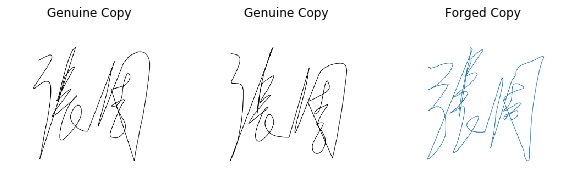

In [24]:
visualize_sample_signature()

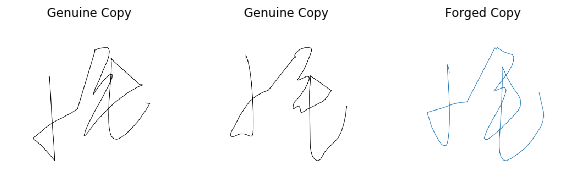

In [25]:
visualize_sample_signature()

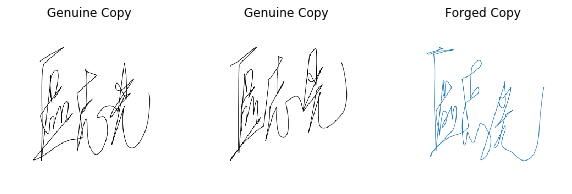

In [26]:
visualize_sample_signature()

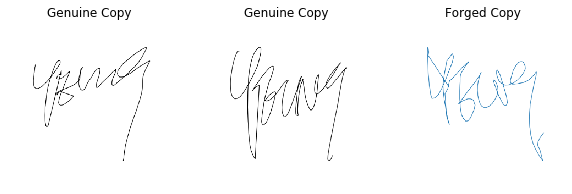

In [27]:
visualize_sample_signature()

(-0.5, 299.5, 299.5, -0.5)

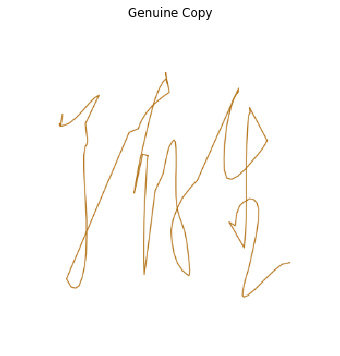

In [28]:
src = cv2.imread(forg_train[0][10], cv2.IMREAD_UNCHANGED)
#percent by which the image is resized
scale_percent = 200

#calculate the 50 percent of original dimensions
#width = int(src.shape[1] * scale_percent / 100)
#height = int(src.shape[0] * scale_percent / 100)

# dsize
#dsize = (width, height)
dsize = (300, 300)

# resize image
output = cv2.resize(src, dsize)

fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.imshow(output, cmap='gray')
ax1.set_title('Genuine Copy')
ax1.axis('off')

In [118]:
# Now we will perform serval data augmentation 
# They can be a. Change in Aspect ratio b. Rotation by 30 degrees in
# clockwise direction c. Right Shear d. Rotation by 10 degrees clockwise e. Left Shear f. Rotation by 30
# degrees in anticlockwise direction g. Gaussian Noise h. Rotation by 10 degrees anticlockwise

def im_resize(image, scale_pr=0):
    src = cv2.imread(image, 0)
    
    #percent by which the image is resized
    scale_percent = scale_pr
    
    if scale_percent ==0:
        width = int(src.shape[1] * scale_percent / 100)
        height = int(src.shape[0] * scale_percent / 100)
        
        # dsize
        dsize = (width, height)
        
    else: dsize = (300, 300)
        
    # resize image
    return cv2.resize(src, dsize)


(-0.5, 589.5, 589.5, -0.5)

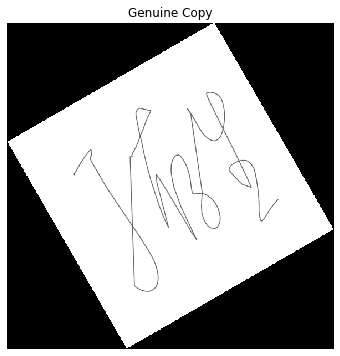

In [30]:
from scipy import ndimage

#rotation angle in degree
src = cv2.imread(orig_train[0][0], 0)
rotated = ndimage.rotate(src, 30)

fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.imshow(rotated, cmap='gray')
ax1.set_title('Genuine Copy')
ax1.axis('off')

In [31]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [79]:
def rotate(image, angle=30, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

(-0.5, 431.5, 431.5, -0.5)

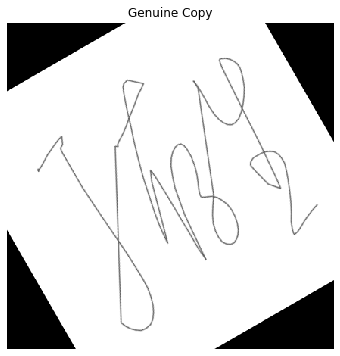

In [33]:
img = rotate(src, 30)
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Genuine Copy')
ax1.axis('off')

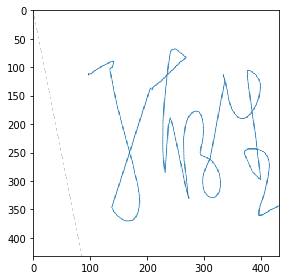

In [34]:
from skimage import io
from skimage import transform as tf

# Load the image as a matrix
image = io.imread(orig_train[0][0])

# Create Afine transform
afine_tf = tf.AffineTransform(shear=0.2)

# Apply transform to image data
modified = tf.warp(image, inverse_map=afine_tf)

# Display the result
io.imshow(modified)
io.show()

In [35]:
type(modified)

numpy.ndarray

In [36]:
# for shearing the images
def shearing(img, shear = 0.6):
    
    # Create Afine transform
    afine_tf = tf.AffineTransform(shear=0.2)
    
    # Apply transform to image data
    modified = tf.warp(img, inverse_map=afine_tf)
    
    # return the result
    return modified


In [45]:
# for adding random gaussian noise to images

row,col = src.shape
ch = 1
mean = 0
var = 0.01
sigma = var**0.5
gauss = np.random.normal(mean,sigma,(row,col,ch))
gauss = gauss.reshape(row,col,ch)
noisy = image + gauss
      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


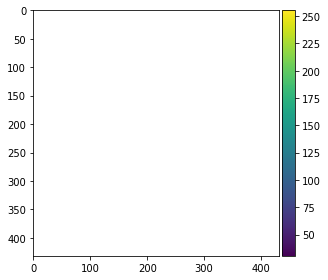

numpy.ndarray

In [46]:
io.imshow(noisy)
io.show()
type(noisy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 431.5, 431.5, -0.5)

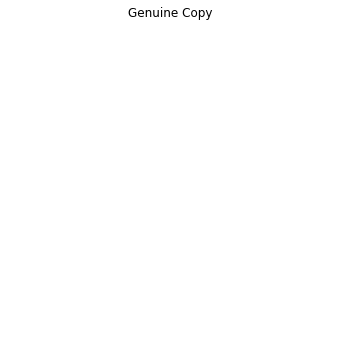

In [47]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.imshow(noisy, cmap='gray')
ax1.set_title('Genuine Copy')
ax1.axis('off')

In [49]:
noisy /= 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 431.5, 431.5, -0.5)

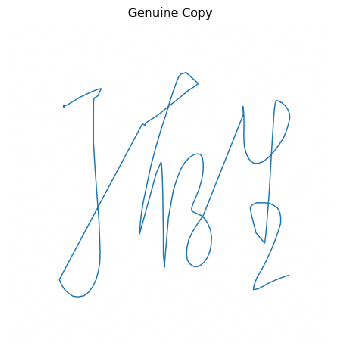

In [50]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.imshow(noisy, cmap='gray')
ax1.set_title('Genuine Copy')
ax1.axis('off')

In [51]:
def gaussian(src, mean = 0, var = 0.01, ch=1):
    
    # for adding random gaussian noise to images
    row,col = src.shape
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    noisy /= 255
    return noisy

In [52]:
"""For data augmentation functions are:
   im_resize(image, scale_pr=0) 
   rotate(image, angle, center = None, scale = 1.0)
   gaussian(src, mean = 0, var = 0.01, ch=1)
   shearing(img, shear = 0.6)"""

'For data augmentation functions are:\n   im_resize(image, scale_pr=0) \n   rotate(image, angle, center = None, scale = 1.0)\n   gaussian(src, mean = 0, var = 0.01, ch=1)\n   shearing(img, shear = 0.6)'

In [55]:
len(orig_train)

50

In [66]:
shuffle([1,2,3,4])

[3, 2, 1, 4]

In [65]:
# Now shufffling the all data
all_orig, all_forg = [], []

for user_data in (orig_train + orig_val + orig_test):
    for i in user_data:
        all_orig.append(i)
        
for user_data in (forg_train + forg_val + forg_test):
    for i in user_data:
        all_forg.append(i)
        
all_orig = shuffle(all_orig)
all_forg = shuffle(all_forg)

len(all_orig), len(all_forg)

(1600, 1600)

In [70]:
labels_orig = np.ones((len(all_orig)), dtype = 'i4')
labels_forg = np.zeros((len(all_forg)),  dtype = 'i4')

In [73]:
all_signature = all_orig + all_forg
all_lables    = list(labels_orig) + list(labels_forg)

all_signature, all_lables = shuffle(all_signature, all_lables)


In [75]:
all_lables[:10]

[0, 0, 0, 1, 0, 0, 0, 0, 1, 1]

In [76]:
all_signature[:10]

['./Task2_/07/U07S18.png',
 './Task1_/30/U30S11.png',
 './Task2_/09/U09S06.png',
 './Task1_/39/U39S30.png',
 './Task2_/39/U39S05.png',
 './Task1_/03/U03S05.png',
 './Task1_/36/U36S05.png',
 './Task1_/02/U02S15.png',
 './Task2_/38/U38S26.png',
 './Task1_/13/U13S34.png']

In [77]:
# we will delete all unnecessary var
del all_orig, all_forg, labels_orig, labels_forg, orig_train, orig_val, orig_test, forg_train, forg_test, forg_val

In [78]:
# [2:8] ratio for tranning to testing
test_signs, val_signs, train_signs = all_signature[:640], all_signature[640:1152], all_signature[1152:] 
test_labls, val_labls, train_labls = all_lables[:640], all_lables[640:1152], all_lables[1152:]

In [149]:
def generate_batch(data_groups, lables, batch_size = 32, for_train = True):
    '''Function to generate a batch of data with batch_size number of data points'''
    img_h, img_w = 64, 128
    
    while True: 
        k = 0
        batch=np.zeros((batch_size, img_h, img_w, 1))
        targets=np.zeros((batch_size,))
        for ix, image in enumerate(data_groups):
            img1 = cv2.imread(image, 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img1 /= 255
            img1 = img1[..., np.newaxis]
            batch[k, :, :, :] = img1
            targets[k] = lables[ix]
            k += 1
            if k == batch_size:
                yield batch, targets
                k = 0
                batch=np.zeros((batch_size, img_h, img_w, 1))
                targets=np.zeros((batch_size,))
    
    
    """if for_train:
        #funs = [im_resize, rotate, gaussian, shearing]
        #now we will first select randomly 10 images from data_groups and apply data preprocessing
        #img_names = random.sample(data_groups, 8)
        #img_lbls  = []
            
        for i in img_names:
            l = 1 if int(i[-6:-4]) > 20 else 0
            img_lbls.append(l)
                
        k = 0
        batch=np.zeros((batch_size, img_h, img_w, 3))
        targets=np.zeros((batch_size,))
            
        for ix, image in enumerate(data_groups):
            img1 = cv2.imread(image, 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img1 /= 255
            img1 = img1[..., np.newaxis]
            batch[k, :, :, :] = img1
            targets[k] = lables[ix]
                
            k += 1
            if k == (batch_size):
                # 8 images will be more proprocessed or augmented and can have any function
                    
                for index, dpim in enumerate(img_names):
                    img_ = cv2.imread(dpim, 0)
                    fun  = random.choice(funs)
                    img_ = fun(img_)
                    img_ = cv2.resize(img_, (img_w, img_h))
                    img_ = np.array(img_, dtype = np.float64)
                    img_ /= 255
                    img_ = img_[...,np.newaxis]
                    batch[k, :, :, :] = img_
                    targets[k] = img_lbls[index]
                    k += 1
                
                yield batch, targets
                k = 0
                batch=np.zeros((batch_size, img_h, img_w, 3))
                targets=np.zeros((batch_size,))
                    
        else:
            k = 0
            batch=np.zeros((batch_size, img_h, img_w, 3))
            targets=np.zeros((batch_size,))
            
            for ix, image in enumerate(data_groups):
                img1 = cv2.imread(image, 0)
                img1 = cv2.resize(img1, (img_w, img_h))
                img1 = np.array(img1, dtype = np.float64)
                img1 /= 255
                img1 = img1[..., np.newaxis]
                batch[k, :, :, :] = img1
                targets[k] = lables[ix]
                k += 1
                if k == batch_size:
                    yield batch, targets
                    k = 0
                    batch=np.zeros((batch_size, img_h, img_w, 3))
                    targets=np.zeros((batch_size,))"""
    
    
            

In [103]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [104]:
Sequential

keras.engine.sequential.Sequential

In [130]:
img_h, img_w = 64, 128
input_shape=(img_h, img_w, 1)

In [106]:
#Creating Base Shallow Network

def base_shallow_signet(input_shape):
    
    #intantiate model 
    model = Sequential()
    
    #Convolution layer 1 with relu activation followed by Maxpooling
    model.add(Conv2D(40, (7, 7), activation='relu', init='random_normal',input_shape=input_shape, strides=1))
    model.add(MaxPooling2D((2, 2),strides=2))
    
    #Convolution layer 2 with relu activation followed by Maxpooling
    model.add(Conv2D(30, (5, 5), activation='relu', init='random_normal',strides =1))
    model.add(MaxPooling2D((3, 3),strides=3))
    
    #Convolution layer 3 with relu activation followed by Maxpooling
    model.add(Conv2D(20, (3, 3), activation='relu', init='random_normal',strides =1))
    model.add(MaxPooling2D((3, 3),strides=3))
    
    #passing it to one fully connected layer
    model.add(Flatten())
    
    #100 users so 100 classes with softmax activation
    model.add(Dense(100, activation='softmax'))
    
    return model

In [107]:
import tensorflow as tf
#optimizer stotestic gradient desent with momentum as per paper
opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

In [132]:
model_  = base_shallow_signet(input_shape)
input_a = Input(shape=(input_shape))

processed_a = model_(input_a)
model = Model(input=[input_a], output=processed_a)

C:\Users\Anshul\.conda\envs\env1\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(40, (7, 7), activation="relu", input_shape=(64, 128, ..., strides=1, kernel_initializer="random_normal")`
  if __name__ == '__main__':
C:\Users\Anshul\.conda\envs\env1\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (5, 5), activation="relu", strides=1, kernel_initializer="random_normal")`
  del sys.path[0]
C:\Users\Anshul\.conda\envs\env1\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (3, 3), activation="relu", strides=1, kernel_initializer="random_normal")`
C:\Users\Anshul\.conda\envs\env1\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("se...)`
  """


In [143]:
#network defination
#import keras

#model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])

In [145]:
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [146]:
model.compile(loss=contrastive_loss, optimizer=rms, metrics=['accuracy'])

In [147]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 128, 1)        0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 100)               57550     
Total params: 57,550
Trainable params: 57,550
Non-trainable params: 0
_________________________________________________________________


In [111]:
os.getcwd()

'C:\\Users\\Anshul\\OneDrive\\Desktop\\SVC-2004'

In [112]:
os.mkdir('Weights')

In [150]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/cnn_signet_svc-2004{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [137]:
batch_sz = 32

In [138]:
num_train_samples = len(train_signs)
num_val_samples = len(val_signs)
num_test_samples = len(test_signs)
num_train_samples, num_val_samples, num_test_samples

(2048, 512, 640)

In [140]:
os.getcwd()

'C:\\Users\\Anshul\\OneDrive\\Desktop\\SVC-2004'

In [151]:
results = model.fit_generator(generate_batch(train_signs, lables = train_labls, batch_size=batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(val_signs, lables= val_labls, batch_size=10),
                              validation_steps = num_val_samples//10,
                              callbacks = callbacks)

Epoch 1/100
64/64 [==============================] - 58s 910ms/step - loss: 0.4829 - accuracy: 0.0000e+00 - val_loss: 0.4901 - val_accuracy: 0.0000e+00

Epoch 00001: saving model to ./Weights/cnn_signet_svc-2004001.h5
Epoch 2/100
64/64 [==============================] - 62s 967ms/step - loss: 0.4829 - accuracy: 0.0000e+00 - val_loss: 0.4901 - val_accuracy: 0.0000e+00

Epoch 00002: saving model to ./Weights/cnn_signet_svc-2004002.h5
Epoch 3/100
64/64 [==============================] - 69s 1s/step - loss: 0.4829 - accuracy: 0.0000e+00 - val_loss: 0.4901 - val_accuracy: 0.0000e+00

Epoch 00003: saving model to ./Weights/cnn_signet_svc-2004003.h5
Epoch 4/100
64/64 [==============================] - 70s 1s/step - loss: 0.4829 - accuracy: 0.0000e+00 - val_loss: 0.4901 - val_accuracy: 0.0000e+00

Epoch 00004: saving model to ./Weights/cnn_signet_svc-2004004.h5
Epoch 5/100
64/64 [==============================] - 65s 1s/step - loss: 0.4829 - accuracy: 0.0000e+00 - val_loss: 0.4901 - val_accura

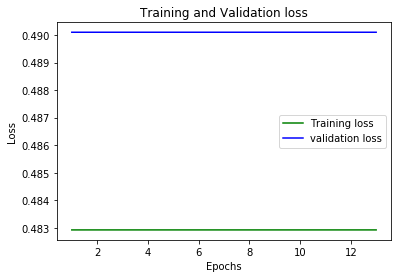

In [162]:
loss_train = results.history['loss']
loss_val = results.history['val_loss']
epochs = range(1,14)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def compute_accuracy_roc(predictions, labels, plot_far_frr =False):
    '''
    Compute ROC accuracy with a range of thresholds on distances.
    Plot FAR-FRR and P-R curves to measure performance on input set
    '''
    """neg = 0
    pos = 1
    tp, tn , fp, fn = 0, 0, 0, 0
    
    for i in range(len(labels)):
        if predictions[i] == pos:
            if labels[i] == pos:
                tp += 1
            else:
                fp += 1
        else:
            if labels[i] == neg:
                tn += 1
            else:
                fn += 1

    cm       = numpy.array([[tn, fp],[fn, tp]])
    #measures = [TP, FP, TN, FN]
    accuracy = (tn+tp)/(tn+tp+fp+fn)
    TP, TN, FP, FN = tp, tn, fp, fn
    precision= TP/(FP+TP)                                                  #Positive predicted Value
    recall   = TP/(FN+TP)                                                  #hit / treu Positive rate
    TNR      = FP/(TN+FP)
    NPV      = TN/(TN+FN)
    FPV      = FN/(TP+FN)
    F1_Score = 2*TP/(2*TP+FP+FN)
    MCC      = (TP*TN - FP*FN) / ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**(1/2)  #mathematical correlation coefficient
    
    return accuracy"""

    
    
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1) #similar
    ndiff = np.sum(labels == 0) #different
    step = 0.00001
    max_acc = 0
    best_thresh = -1
    frr_plot = []
    far_plot = []
    pr_plot = []
    re_plot = []
    ds = []
    for d in np.arange(dmin, dmax+step, step):

        idx1 = predictions.ravel() <= d #guessed genuine
        idx2 = predictions.ravel() > d #guessed forged
        tp = float(np.sum(labels[idx1] == 1))
        tn = float(np.sum(labels[idx2] == 0))
        fp = float(np.sum(labels[idx1] == 0))
        fn = float(np.sum(labels[idx2] == 1))
#         print(tp, tn, fp, fn)
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        
        
        acc = 0.5 * (tpr + tnr)
        pr = tp / (tp + fp)
        re = tp / (tp + fn)
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
        
        #if (fp+tn) != 0.0 and (fn+tp) != 0.0:
        far = fp / (fp + tn)
        frr = fn / (fn + tp)
        frr_plot.append(frr)
        pr_plot.append(pr)
        re_plot.append(re)
        far_plot.append(far)
        ds.append(d)
            
    
    if plot_far_frr:
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(121)
        ax.plot(ds, far_plot, color = 'red')
        ax.plot(ds, frr_plot, color = 'blue')
        ax.set_title('Error rate')
        ax.legend(['FAR', 'FRR'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        ax1 = fig.add_subplot(122)
        ax1.plot(ds, pr_plot, color = 'green')
        ax1.plot(ds, re_plot, color = 'magenta')
        ax1.set_title('P-R curve')
        ax1.legend(['Precision', 'Recall'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        plt.show()
    return max_acc, best_thresh

In [ ]:
# Load the weights from the epoch which gave the best validation accuracy

def load_and_check_model(weight):
    model.load_weights(weight)

    val_gen = generate_batch(val_signs, lables=val_labls, batch_size= 1)
    pred, tr_y = [], []
    for i in range(num_val_samples):
        img1, label = next(val_gen)
        tr_y.append(label[0])
        pred.append(model.predict(img1)[0][0])
        
    arr = np.array(pred)

    acc = compute_accuracy_roc(arr, np.array(tr_y))
    return acc

In [ ]:
os.getcwd()

In [202]:
acc_thresh = []
for i in range(1,14,1):
    acc_thresh.append(load_and_check_model('./Weights/cnn_signet_svc-200400'+str(i)+'.h5'))
    print('For model '+str(i)+' Validation Accuracy = ',acc_thresh[i-1][0]*100,'%')

[0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.010000954, 0.009999925, 0.009999925, 0.009999925, 0.009999949, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009990754, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.010000158, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999961, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.009999925, 0.010000109, 0.010001532, 0.009999925, 0.009999925, 0.009999925

In [203]:
print(results.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


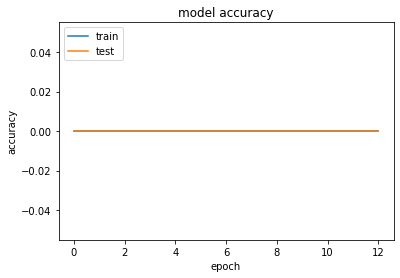

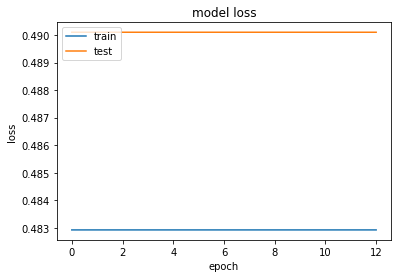

In [205]:
history = results
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()